In [10]:
using PyCall

In [3]:
pushfirst!(PyVector(pyimport("sys")."path"), "")
constants = pyimport("constants")

PyObject <module 'constants' from '/media/data/hastings/ct-angledslice-align/constants.py'>

In [4]:
ultrasoundgeneration = pyimport("ultrasoundgeneration")
itk = pyimport("itk")
np = pyimport("numpy")

PyObject <module 'numpy' from '/home/hastings/anaconda3/lib/python3.7/site-packages/numpy/__init__.py'>

In [5]:
#tdata, tclasses = ultrasoundgeneration.load_dataset(ultrasoundgeneration.test_volumes_path)

names = readdir(ultrasoundgeneration.test_volumes_path)



8-element Array{String,1}:
 "Pancreas_10.nrrd"
 "Pancreas_11.nrrd"
 "Pancreas_12.nrrd"
 "Pancreas_13.nrrd"
 "Pancreas_6.nrrd" 
 "Pancreas_7.nrrd" 
 "Pancreas_8.nrrd" 
 "Pancreas_9.nrrd" 

In [6]:
using StaticArrays
using CuArrays, CUDAnative
using CuArrays, CuTextures
using NRRD

Vec3 = SVector{3,Float32}
Mat3 = SMatrix{3, 3, Float32, 9}

struct TwoSensorProbe
    side_offset::Float64
    angle::Float64
end

struct SliceParams #measured from center
    origin::Array{Float64,1}
    direction::Array{Float64, 2}
    width::Float64
    height::Float64
    px::Int64
end

struct ItkImage
    texture::Any
    direction::Mat3
    spacing::Vec3
    ItkImage(pyobject) = new(
        CuTexture(CuTextureArray(Float32.(np.array(pyobject)))), 
        Mat3(itk.array_from_matrix(pyobject.GetDirection())),
        Vec3(np.array(pyobject.GetSpacing()))
    )
end


    

function get_origin_direction(probe::TwoSensorProbe, origin, direction, idx)
    @assert(idx == 1 || idx == -1)
    @. origin = origin + idx * probe.side_offset * direction[:, 3]
    angle = probe.angle * idx
    direction = direction * [1 0 0; 0 cos(angle) sin(angle); 0 -sin(angle) cos(angle)]
    return origin, direction
end

┌ Info: Precompiling CuArrays [3a865a2d-5b23-5a0f-bc46-62713ec82fae]
└ @ Base loading.jl:1273
┌ Info: Precompiling CuTextures [44f18228-da5a-4172-9251-368da0040bb3]
└ @ Base loading.jl:1273


get_origin_direction (generic function with 1 method)

In [12]:
using PyPlot

┌ Info: Precompiling PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1273


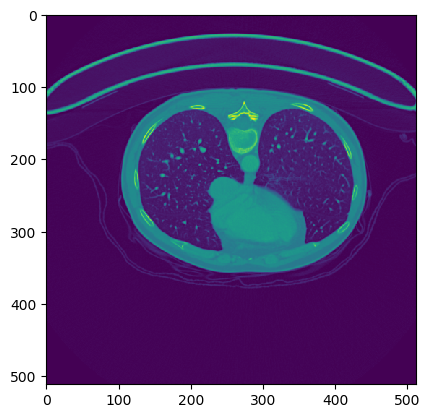

In [13]:

image, annotation = ultrasoundgeneration.load_image_annotation(
    names[1], ultrasoundgeneration.test_volumes_path)

iarray = np.array(image)
jimage = ItkImage(image)
imshow(iarray[1, :, :, 1])
show()

In [28]:
function random_small_rotation(factor)
    R, _ = qr(randn((3, 3)))
    lambda, J = eigen(R)
    return real(J * Diagonal(lambda .^ (1 / factor)) * inv(J))
end

random_small_rotation (generic function with 1 method)

In [181]:
dict = ultrasoundgeneration.generate_sample(image, annotation, evil_debug=true)

Dict{Any,Any} with 3 entries:
  "classes" => Array{Float64,N} where N[[-10.621, -0.0569037, -10.3927], [0.995…
  "data"    => Array{Int16,2}[[328 345 … 20 17; 277 256 … 51 41; … ; -89 -83 … …
  "locals"  => Dict{Any,Any}("c"=>Int16[23 28 … 232 150; 44 31 … 252 184; … ; -…

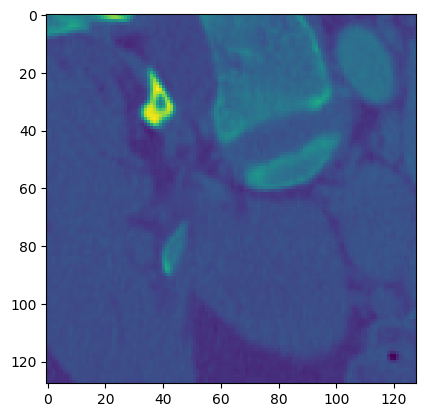

PyObject <matplotlib.image.AxesImage object at 0x7fbe1571c6d0>

In [188]:
imshow(dict["data"][1])

In [183]:
vals = dict["locals"]

Dict{Any,Any} with 16 entries:
  "c"                            => Int16[23 28 … 232 150; 44 31 … 252 184; … ;…
  "annotations"                  => Array{Float64,1}[[116.484, 116.484, 117.305…
  "b"                            => Int16[74 62 … 131 144; 71 86 … 137 152; … ;…
  "a"                            => Int16[328 345 … 20 17; 277 256 … 51 41; … ;…
  "slice_idx"                    => 127
  "rotation_relative_to_image_1" => [0.995952 -0.0869646 -0.0227257; 0.0859034 …
  "horror"                       => Dict{Any,Any}()
  "movement_relative_to_image_1" => [-10.621, -0.0569037, -10.3927]
  "origin_2"                     => [207.629, -150.11, -138.831]
  "origin"                       => [219.386, -159.191, -139.165]
  "d"                            => Int16[55 61 … 113 89; 56 63 … 130 102; … ; …
  "image"                        => PyObject <itk.itkImagePython.itkImageSS3; p…
  "direction"                    => [0.138025 0.024274 0.990131; -0.988733 0.06…
  "direction_2"               

In [30]:
#generate sample

function generate_sample(jimage, annotation)
    initial_position_randomness_scale = 15 #mm
    movement_scale = 10 #mm
    slice_idx = rand(50:length(annotation[1]) - 50)

    direction = random_small_rotation(15) * [0 0 1; -1 0 0; 0 -1 0]

    #direction = vals["direction"]

    # depends on annotation having 1 mm spacing along spine
    origin = (
        [annotation[2][slice_idx], -annotation[1][slice_idx], -slice_idx] 
        .+ initial_position_randomness_scale .* randn(Float64, 3) 
    )

    #debug
    #origin = vals["origin"]

    probe = TwoSensorProbe(20, -np.pi / 4)

    a, b = slice_multiprobe(jimage, probe, origin, direction)

    movement_relative_to_image_1 = randn(3) .* movement_scale
    rotation_relative_to_image_1 = random_small_rotation(25)

    direction_2 = direction * rotation_relative_to_image_1
    origin_2 = origin .+ direction * movement_relative_to_image_1

    c, d = slice_multiprobe(jimage, probe, origin, direction)

    return Dict(["data"=> [a, b, c, d], "classes"=> [movement_relative_to_image_1, rotation_relative_to_image_1]])
end

generate_sample (generic function with 1 method)

In [7]:
function reverse(v::Vec3)
    return Vec3(v[3], v[2], v[1])
end


function warp(dst, texture, origin::Vec3, direction::Mat3, image_direction::Mat3, image_spacing::Vec3)
    i::Int32 = (blockIdx().x - 1) * blockDim().x + threadIdx().x
    j::Int32 = (blockIdx().y - 1) * blockDim().y + threadIdx().y
    #u = (Float32(i) - 1f0) / (Float32(size(dst, 1)) - 1f0)
    #v = (Float32(j) - 1f0) / (Float32(size(dst, 2)) - 1f0)
    #x = u  #+ 0.02f0 * CUDAnative.sin(30v)
    #y = v #+ 0.03f0 * CUDAnative.sin(20u)
    
    pixel_position = origin .+ direction[:, 1] .* Float32(j) 
    pixel_position = pixel_position .+ direction[:, 2] .* Float32(i)
    
    pixel_position = pixel_position ./ image_spacing
    direction_flat = (image_direction[1, 1], image_direction[2, 2], image_direction[3, 3])
    pixel_position = pixel_position ./ direction_flat
    
    
    @inbounds dst[i,j] = texture(pixel_position[3] / 223, pixel_position[2] / 512, pixel_position[1] / 512)
    return nothing
end

using LinearAlgebra
function spine_slice(image, params)
    output_direction = params.direction * Diagonal([params.height / params.px, params.width / params.px, 0])
    
    output_origin = params.origin .+ params.direction * [-params.height / 2; -params.width / 2; 0]
    
    outimg_d = CuArray{Float32}(undef, 128, 128)
    @cuda threads = (128, 1) blocks = (1, 128) warp(
        outimg_d, image.texture, Vec3(output_origin), Mat3(output_direction), jimage.direction, jimage.spacing
    )
    return Array(outimg_d)
end

spine_slice (generic function with 1 method)

In [32]:
function slice_multiprobe(jimage, probe, origin, direction)
    res = []
    params_array = []
    for idx = [-1, 1]
        slice_origin, slice_direction = get_origin_direction(probe, origin, direction, idx)
        #println(slice_origin)
        #print(slice_direction)
        params = SliceParams(slice_origin, slice_direction, 100, 100, 128)
        x = spine_slice(jimage, params)
        push!(res, x)
        push!(params_array, params)
    end
    return res
end

slice_multiprobe (generic function with 1 method)

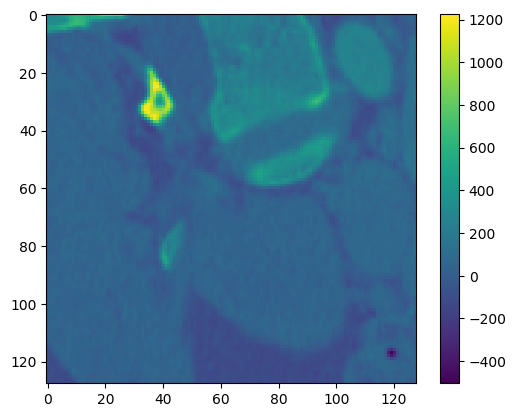

PyObject <matplotlib.colorbar.Colorbar object at 0x7fbe153eda90>

In [288]:
imshow(res[1])
colorbar()

In [26]:
imshow(dict["data"][1])
colorbar()

UndefVarError: UndefVarError: dict not defined

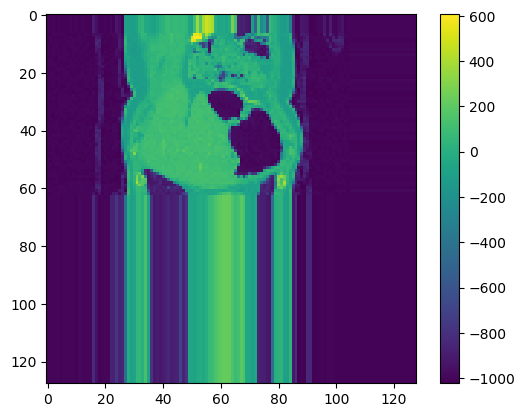

PyObject <matplotlib.colorbar.Colorbar object at 0x7fbe10775510>

In [290]:
params1 = SliceParams([256, -256, 0.], [1 0 0; 0 0 1; 0 1 0], 500, 500, 128)
params2 = ultrasoundgeneration.SliceParams([256., -256., 0.], [1. 0. 0.; 0 0 1; 0 1 0], 500, 500, 128)
imshow(spine_slice(jimage, params1))
colorbar()


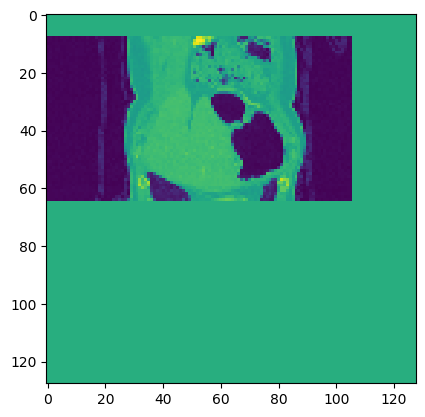

PyObject <matplotlib.image.AxesImage object at 0x7fbe1070e710>

In [291]:
imshow(np.array(ultrasoundgeneration.spine_slice(image, params2))[1, :, :])

In [292]:
@time ultrasoundgeneration.spine_slice(image, params2)
#@btime spine_slice(jimage, params1)

  0.002823 seconds (14 allocations: 560 bytes)


PyObject <itk.itkImagePython.itkImageSS3; proxy of <Swig Object of type 'itkImageSS3 *' at 0x7fbe109599f0> >

In [293]:
generate_sample(jimage, annotation)

[211.6563908514352, -148.2465832299745, -119.83163609640411]
[0.11018373592326962 -0.6489572076327768 0.7528041491646152; -0.9938551554799042 -0.0638926213166964 0.09038618737006607; -0.010558137336038331 -0.7581373725142102 -0.652009394206282][231.480290071369, -146.06475139365867, -118.33075983370102]
[0.11018373592326962 0.7528041491646151 0.6489572076327769; -0.9938551554799042 0.09038618737006607 0.06389262131669643; -0.010558137336038331 -0.6520093942062821 0.7581373725142101][211.6563908514352, -148.2465832299745, -119.83163609640411]
[0.11018373592326962 -0.6489572076327768 0.7528041491646152; -0.9938551554799042 -0.0638926213166964 0.09038618737006607; -0.010558137336038331 -0.7581373725142102 -0.652009394206282][231.480290071369, -146.06475139365867, -118.33075983370102]
[0.11018373592326962 0.7528041491646151 0.6489572076327769; -0.9938551554799042 0.09038618737006607 0.06389262131669643; -0.010558137336038331 -0.6520093942062821 0.7581373725142101]

Dict{String,Array{T,1} where T} with 2 entries:
  "classes" => Array{Float64,N} where N[[3.25474, -2.49151, -29.1361], [0.99493…
  "data"    => Array{Float32,2}[[-67.668 -100.746 … -95.1133 -97.2266; -54.5234…

In [32]:
function doit()
    res= zeros(5012, 128, 128)
    for i = 1:5012
        outimg_d = CuArray{Float32}(undef, 128, 128)
        @cuda threads = (128, 1) blocks = (1, 128) warp(
            outimg_d, jimage.texture, Vec3(origin), Mat3(direction), jimage.direction, jimage.spacing
        )
        res[i, :, :] = Array(outimg_d)
    end
    return res
end



doit (generic function with 1 method)

In [36]:
@time doit()

  1.555149 seconds (551.33 k allocations: 968.123 MiB)


5012×128×128 Array{Float64,3}:
[:, :, 1] =
 -109.332  -105.391  -52.1914  -58.3164  …  -40.6953  -84.6445  -117.137
 -109.332  -105.391  -52.1914  -58.3164     -40.6953  -84.6445  -117.137
 -109.332  -105.391  -52.1914  -58.3164     -40.6953  -84.6445  -117.137
 -109.332  -105.391  -52.1914  -58.3164     -40.6953  -84.6445  -117.137
 -109.332  -105.391  -52.1914  -58.3164     -40.6953  -84.6445  -117.137
 -109.332  -105.391  -52.1914  -58.3164  …  -40.6953  -84.6445  -117.137
 -109.332  -105.391  -52.1914  -58.3164     -40.6953  -84.6445  -117.137
 -109.332  -105.391  -52.1914  -58.3164     -40.6953  -84.6445  -117.137
 -109.332  -105.391  -52.1914  -58.3164     -40.6953  -84.6445  -117.137
 -109.332  -105.391  -52.1914  -58.3164     -40.6953  -84.6445  -117.137
 -109.332  -105.391  -52.1914  -58.3164  …  -40.6953  -84.6445  -117.137
 -109.332  -105.391  -52.1914  -58.3164     -40.6953  -84.6445  -117.137
 -109.332  -105.391  -52.1914  -58.3164     -40.6953  -84.6445  -117.137
    ⋮   

In [ ]:
def random_small_rotation(factor = 10):
    R = scipy.linalg.orth(np.random.randn(3, 3).astype(np.float64))
    lam, J = scipy.linalg.eig(R)
    RR = np.real(np.dot(np.dot(J, np.diag(lam)**(1 / factor)), np.linalg.inv(J)))
    return RR

LinearAlgebra.QRCompactWY{Float64,Array{Float64,2}}
Q factor:
3×3 LinearAlgebra.QRCompactWYQ{Float64,Array{Float64,2}}:
 -0.801873   0.573032  0.169216
  0.053796  -0.212817  0.97561 
  0.595068   0.791419  0.139826
R factor:
3×3 Array{Float64,2}:
 -0.313783   0.511622  -1.77726   
  0.0       -0.979407  -0.823139  
  0.0        0.0       -0.00339869

In [207]:
import LinearAlgebra

In [ ]:
LinearAlgebra.

In [281]:
[1, 2, 3] * [1 0 1; 0 1 0; 0 0 1]

DimensionMismatch: DimensionMismatch("matrix A has dimensions (3,1), matrix B has dimensions (3,3)")

random_small_rotation (generic function with 1 method)

In [241]:
@btime random_small_rotation(2)

  13.235 μs (70 allocations: 13.30 KiB)


3×3 Array{Float64,2}:
  0.448228  0.759783  -0.47098  
 -0.869499  0.492872  -0.0323971
  0.207518  0.424037   0.881549 

In [240]:
using BenchmarkTools

┌ Info: Precompiling BenchmarkTools [6e4b80f9-dd63-53aa-95a3-0cdb28fa8baf]
└ @ Base loading.jl:1273


In [239]:
]add BenchmarkTools

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
Fetching: [========================================>]  99.9 %0.0 %>                                 ]  15.6 %1 %>                     ]  46.7 % [=========================>               ]  62.3 %           ]  71.4 % [===================================>     ]  87.0 % Resolving package versions...


┌ Warning: julia version requirement for package CuTextures not satisfied
└ @ Pkg.Operations /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.3/Pkg/src/Operations.jl:229


 Installed MKL_jll ──────── v2020.1.216+0
 Installed TimerOutputs ─── v0.5.6
 Installed Compat ───────── v3.11.0
 Installed BenchmarkTools ─ v0.5.0
 Installed GeometryBasics ─ v0.2.11
 Installed FFTW ─────────── v1.2.2
 Installed ZMQ ──────────── v1.2.1
 Installed Distributions ── v0.23.4
 Installed Parsers ──────── v1.0.5
 Installed ZeroMQ_jll ───── v4.3.2+4
  Updating `~/.julia/environments/v1.3/Project.toml`
  [6e4b80f9] + BenchmarkTools v0.5.0
  Updating `~/.julia/environments/v1.3/Manifest.toml`
  [6e4b80f9] + BenchmarkTools v0.5.0
  [34da2185] ↑ Compat v3.10.0 ⇒ v3.11.0
  [31c24e10] ↑ Distributions v0.23.3 ⇒ v0.23.4
  [7a1cc6ca] ↑ FFTW v1.2.1 ⇒ v1.2.2
  [5c1252a2] ↑ GeometryBasics v0.2.10 ⇒ v0.2.11
  [856f044c] ↑ MKL_jll v2019.0.117+2 ⇒ v2020.1.216+0
  [69de0a69] ↑ Parsers v1.0.4 ⇒ v1.0.5
  [a759f4b9] ↑ TimerOutputs v0.5.5 ⇒ v0.5.6
  [c2297ded] ↑ ZMQ v1.2.0 ⇒ v1.2.1
  [8f1865be] ↑ ZeroMQ_jll v4.3.2+3 ⇒ v4.3.2+4
  Building FFTW → `~/.julia/packages/FFTW/kcXL6/deps/build.log`


In [42]:
@time [generate_sample(jimage, annotation) for _ = 1:5000]
0

  2.211646 seconds (4.18 M allocations: 1.530 GiB, 22.31% gc time)


0

In [38]:
@time [ultrasoundgeneration.generate_sample(image, annotation) for _ = 1:5000]
0

 29.116295 seconds (2.06 M allocations: 734.378 MiB)


5000-element Array{Dict{Any,Any},1}:
 Dict("classes" => Array{Float64,N} where N[[-7.276436906097055, -12.024495013907918, -5.123752241092623], [0.9964826835314641 -0.07902429390234393 0.02788229537121839; 0.0805911870318081 0.994912538355278 -0.060449165389290974; -0.0229634926510755 0.06248361382549592 0.9977817777493083]],"data" => Array{Int16,2}[[-916 -928 … 52 50; -928 -934 … 35 39; … ; -477 -841 … -83 -74; -389 -806 … -89 -88], [-949 -947 … 298 319; -942 -942 … 257 294; … ; -924 -937 … 35 41; -932 -932 … 41 55], [-944 -952 … 348 369; -928 -942 … 593 597; … ; -930 -930 … 35 55; -947 -927 … 47 41], [-939 -945 … 276 233; -935 -941 … 276 268; … ; -913 -910 … 42 33; -909 -907 … 38 36]],"locals" => Dict{Any,Any}())                        
 Dict("classes" => Array{Float64,N} where N[[-10.68678251351178, 0.07990317337223994, 12.754232819414973], [0.9961430400646288 0.06506904745160744 -0.05886478399297686; -0.06532089677771157 0.9978615133383308 -0.0023623383102775453; 0.0585851873339576